In [56]:
import sys

sys.path.append("../")
from config.get_config import get_config

# Load Data

In [57]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import mlflow

from sklearn.metrics import mean_squared_error

In [58]:
sys.path.append("../src")
from pipeline.factory import Factory
from preprocessing.process_raw_data import load_data

config = dict(get_config())
data_config = dict(config["data"])

mlflow.set_tracking_uri("http://0.0.0.0:5000")
e = mlflow.set_experiment(data_config["mlflow_experiment_name"])

In [59]:
# fix paths
for k, v in data_config["paths"].items():
    for k2, v2 in v.items():
        data_config["paths"][k][k2] = "../" + v2

In [60]:
df = load_data(data_config["paths"])
f = Factory(data_config)
f.fit(df)

Fitting data ...


/home/acaille/.cache/pypoetry/virtualenvs/stores-sales-forecasting-poc-oU5uZx8Y-py3.10/lib/python3.10/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
/home/acaille/.cache/pypoetry/virtualenvs/stores-sales-forecasting-poc-oU5uZx8Y-py3.10/lib/python3.10/site-packages/pandas/core/generic.py:6915: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)


## Data Viz

In [61]:
train, val = f.get_df()
data = pd.concat([train, val])

In [62]:
train.head()

,onpromotion,dcoilwtico,cluster,sales,typedays_Additional,typedays_Event,typedays_Holiday,typedays_Normal
2013-01-01,0.0,0.792965,0.0,2511.618999,False,False,True,False
2013-01-02,0.0,0.792965,0.0,496092.417944,False,False,False,True
2013-01-03,0.0,0.790951,0.0,361461.231124,False,False,False,True
2013-01-04,0.0,0.792728,0.0,354459.677093,False,False,False,True
2013-01-05,0.0,0.793044,0.0,348347.385084,False,False,False,True


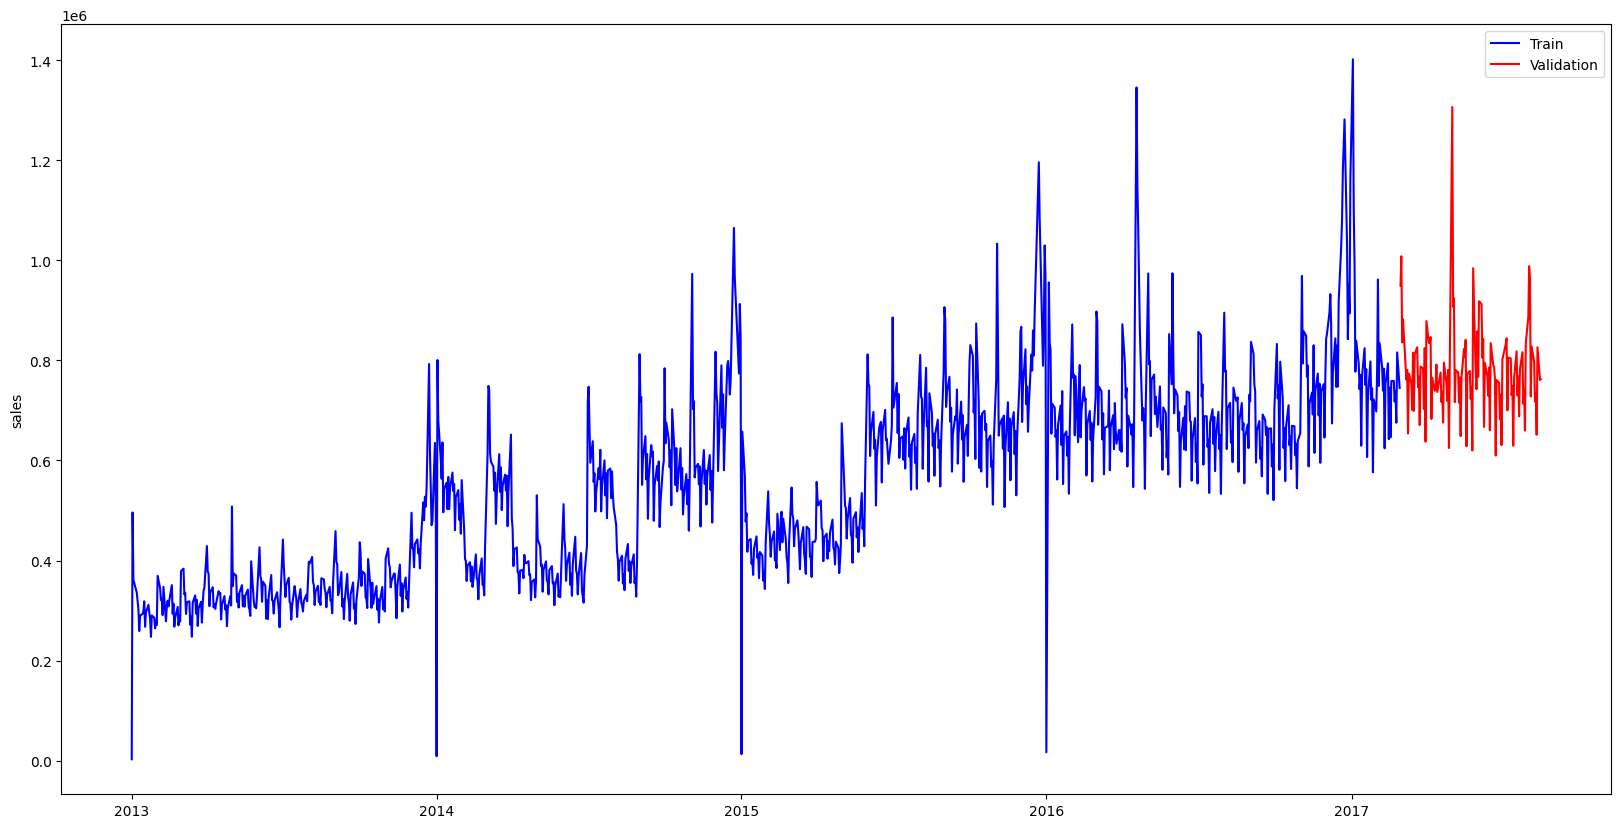

In [63]:
plt.figure(figsize=(20, 10))
sns.lineplot(data=train, x=train.index, y="sales", color="blue", label="Train")
sns.lineplot(data=val, x=val.index, y="sales", color="red", label="Validation")
plt.legend()

# Models fit

In [64]:
def predict_and_plot(model_name):
    model_type = model_name.split(" ")[0]
    model = model_name.split(" ")[1]
    id = (
        mlflow.search_registered_models(filter_string=f"name = '{model_name}'")[0]
        .latest_versions[0]
        .run_id
    )
    local_config = config[model_type][model]

    f.load_model(id, local_config)
    pred = f.predict()

    print(f"Predicted {len(pred)} days")

    assert len(pred) == len(val)

    df = pd.DataFrame(pred, columns=["yhat"])
    plt.figure(figsize=(20, 10))
    sns.lineplot(
        data=df, x=val.index, y="yhat", color="red", label=f"{model_type} Prediction"
    )
    sns.lineplot(data=val, x=val.index, y="sales", color="blue", label="Validation")

    print(f"RMSE: {mean_squared_error(val['sales'], pred)}")

## Prophet

Predicted 169 days
RMSE: 24472579340.54365


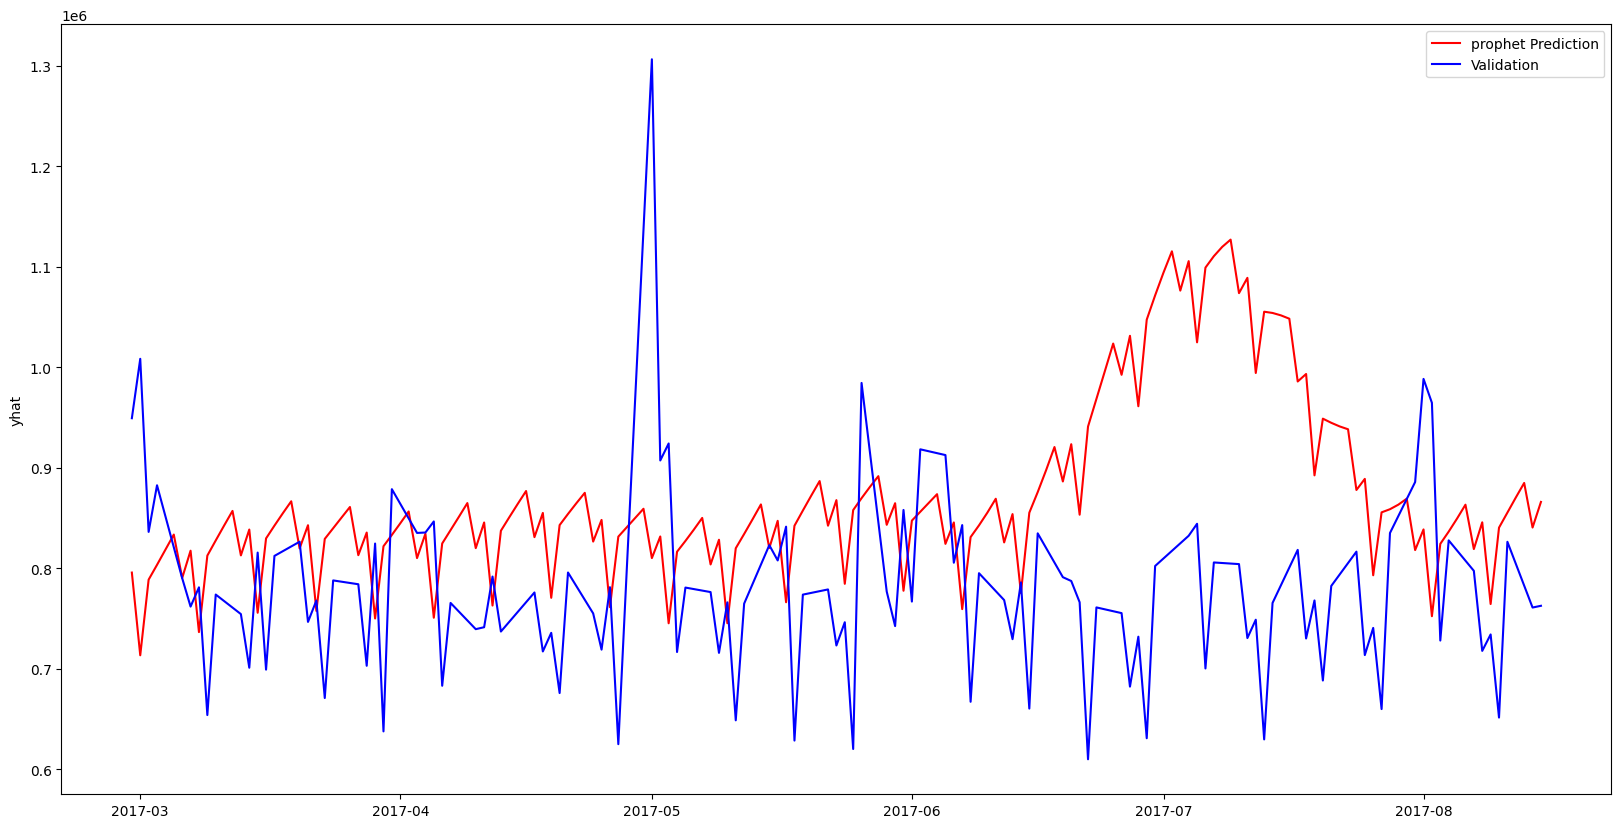

In [65]:
predict_and_plot("prophet default - 2024-01-31 10:24")

Predicted 169 days
RMSE: 27161019387.209255


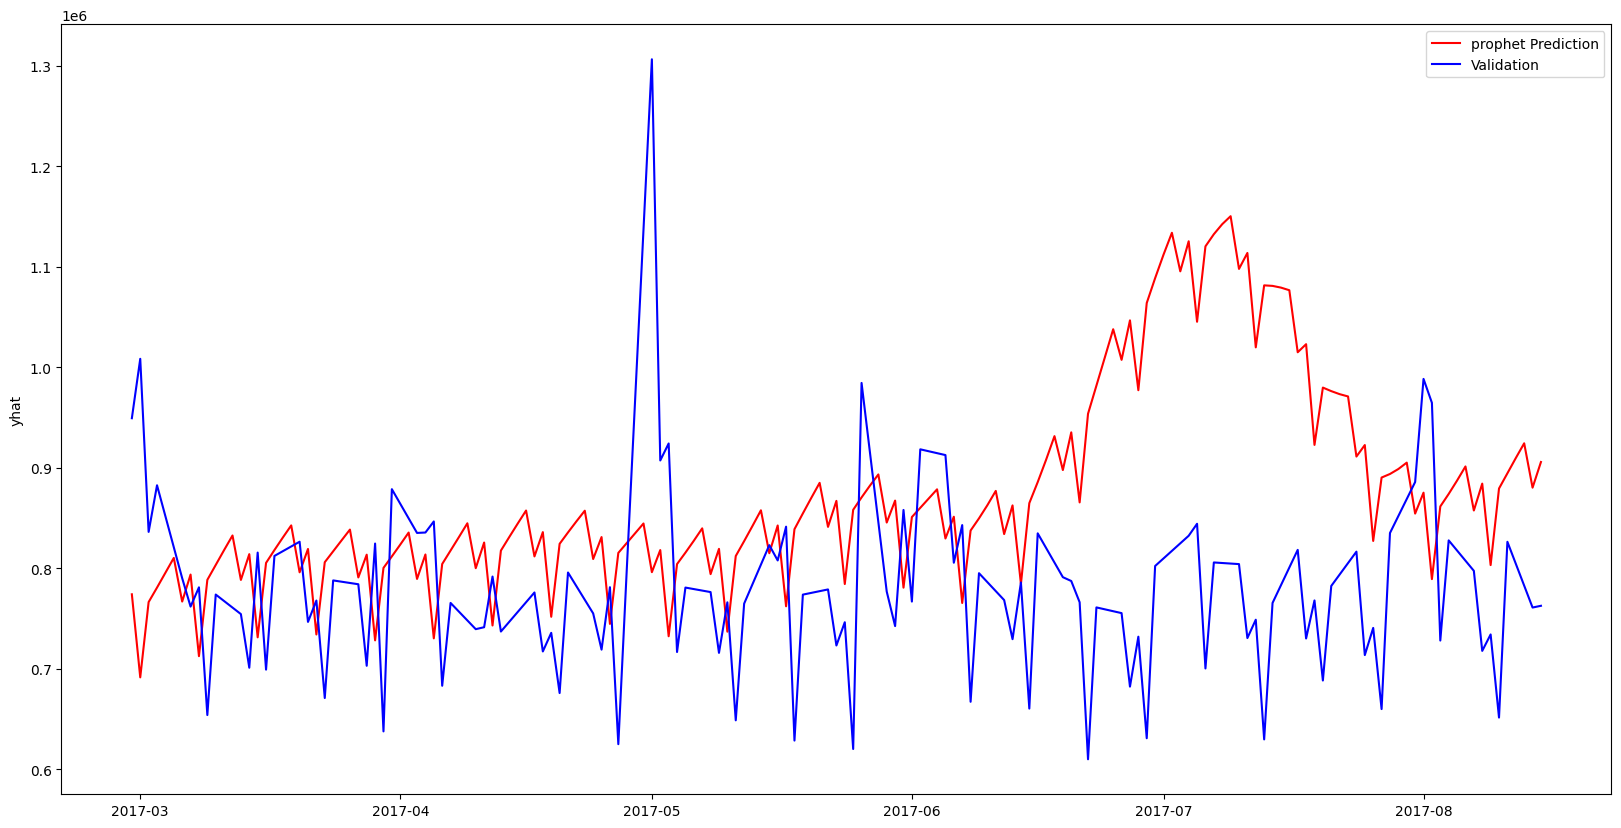

In [66]:
predict_and_plot("prophet changepoint_prior_scale_0_5 - 2024-01-31 10:24")

## Xgboost

Predicted 169 days
RMSE: 7196314373.905072


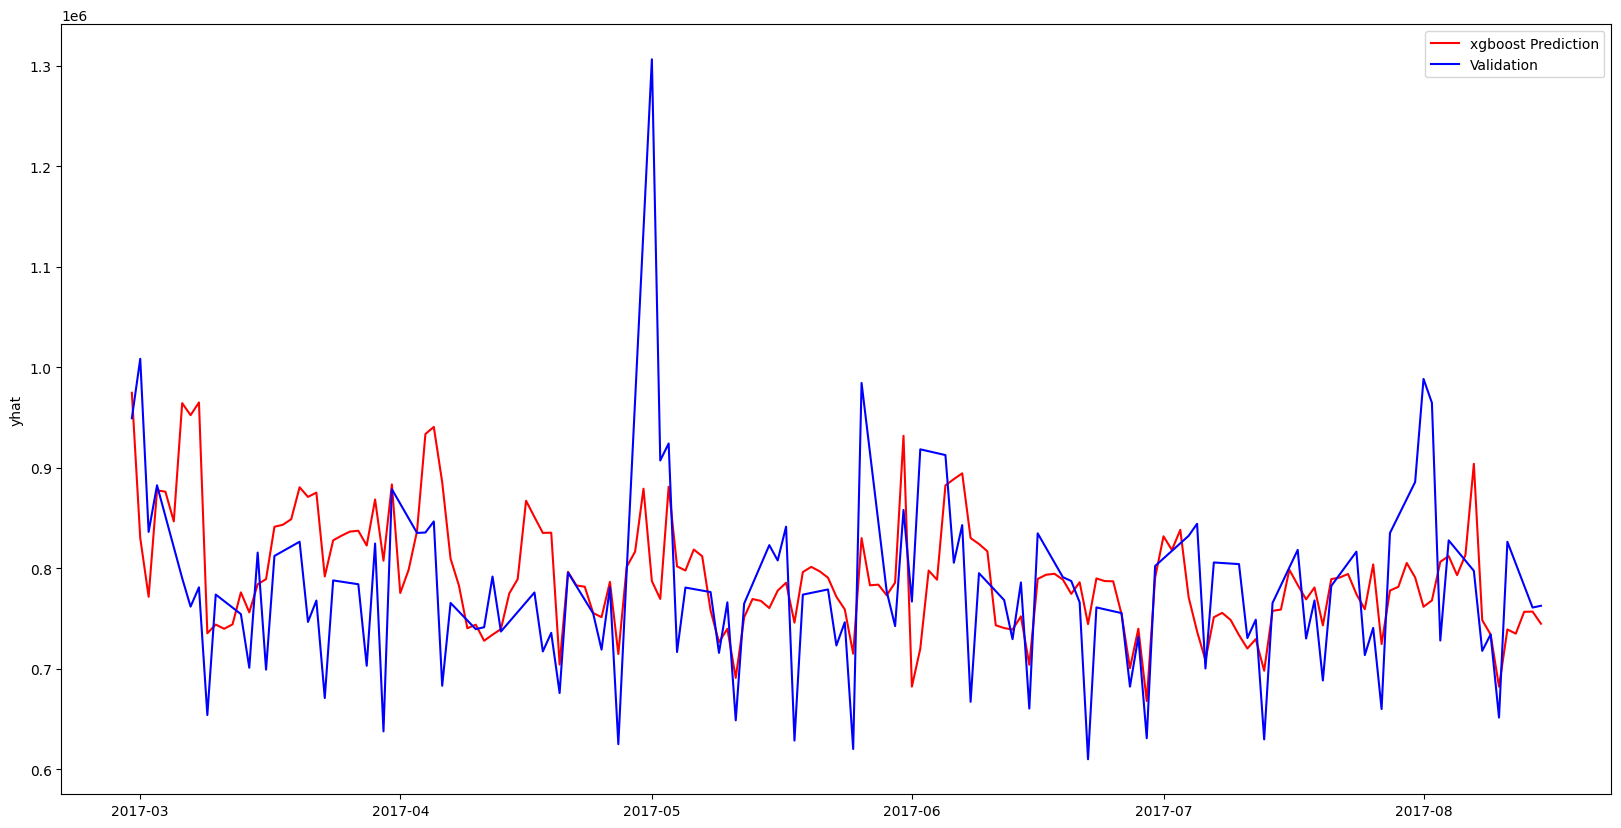

In [67]:
predict_and_plot("xgboost default - 2024-01-31 10:23")

## LSTM simple

1/1 [==============================] - 0s 38ms/step
Predicted 169 days
RMSE: 45574159564.98798


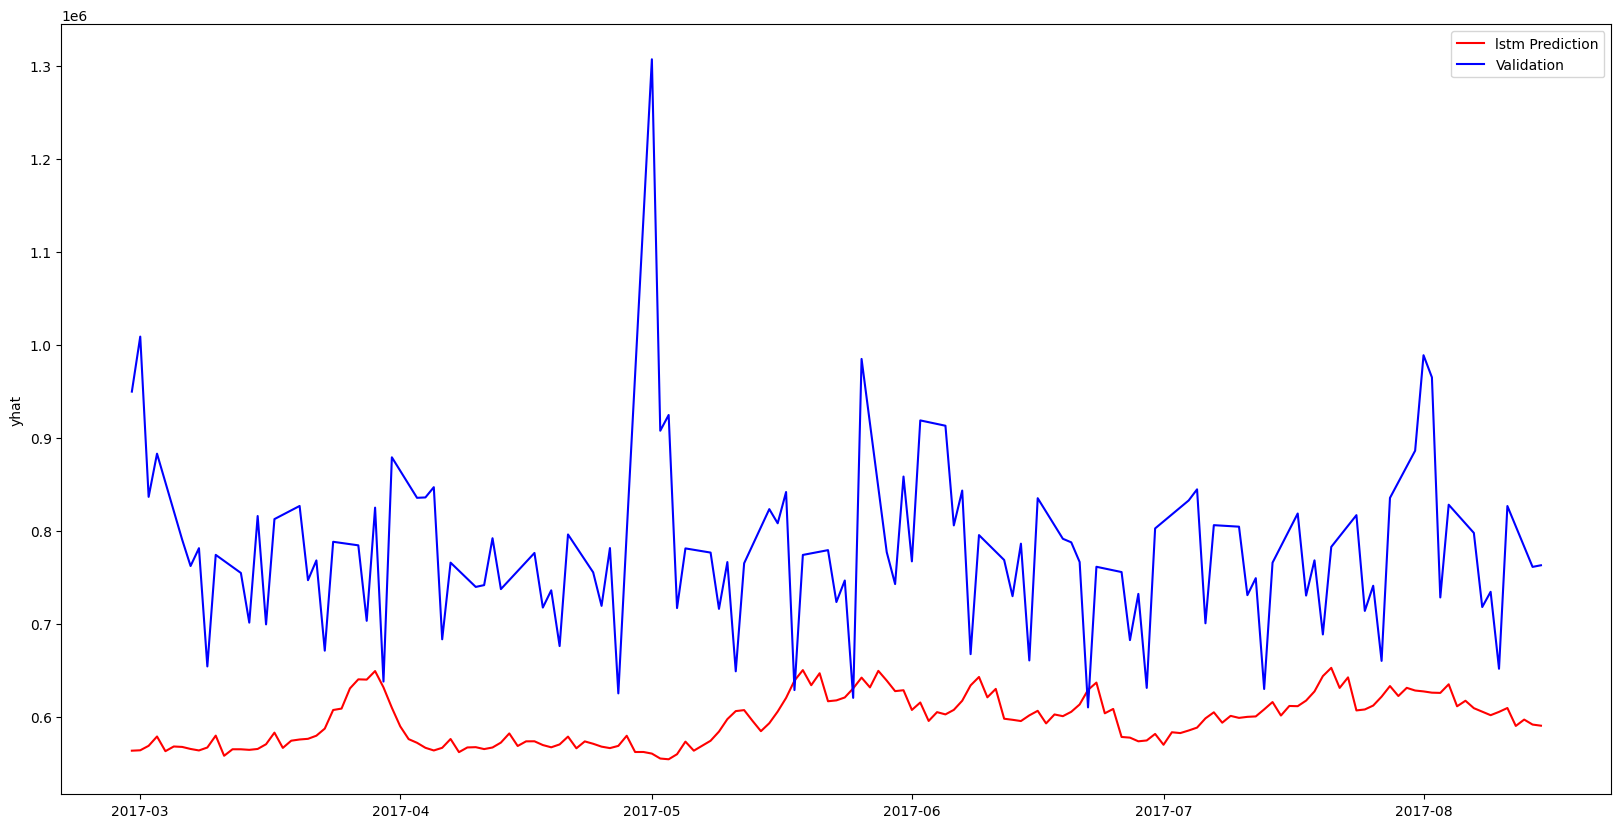

In [73]:
predict_and_plot("lstm default_simple - 2024-01-31 09:48", False);

1/1 [==============================] - 0s 16ms/step
Predicted 169 days
RMSE: 49550234872.37946


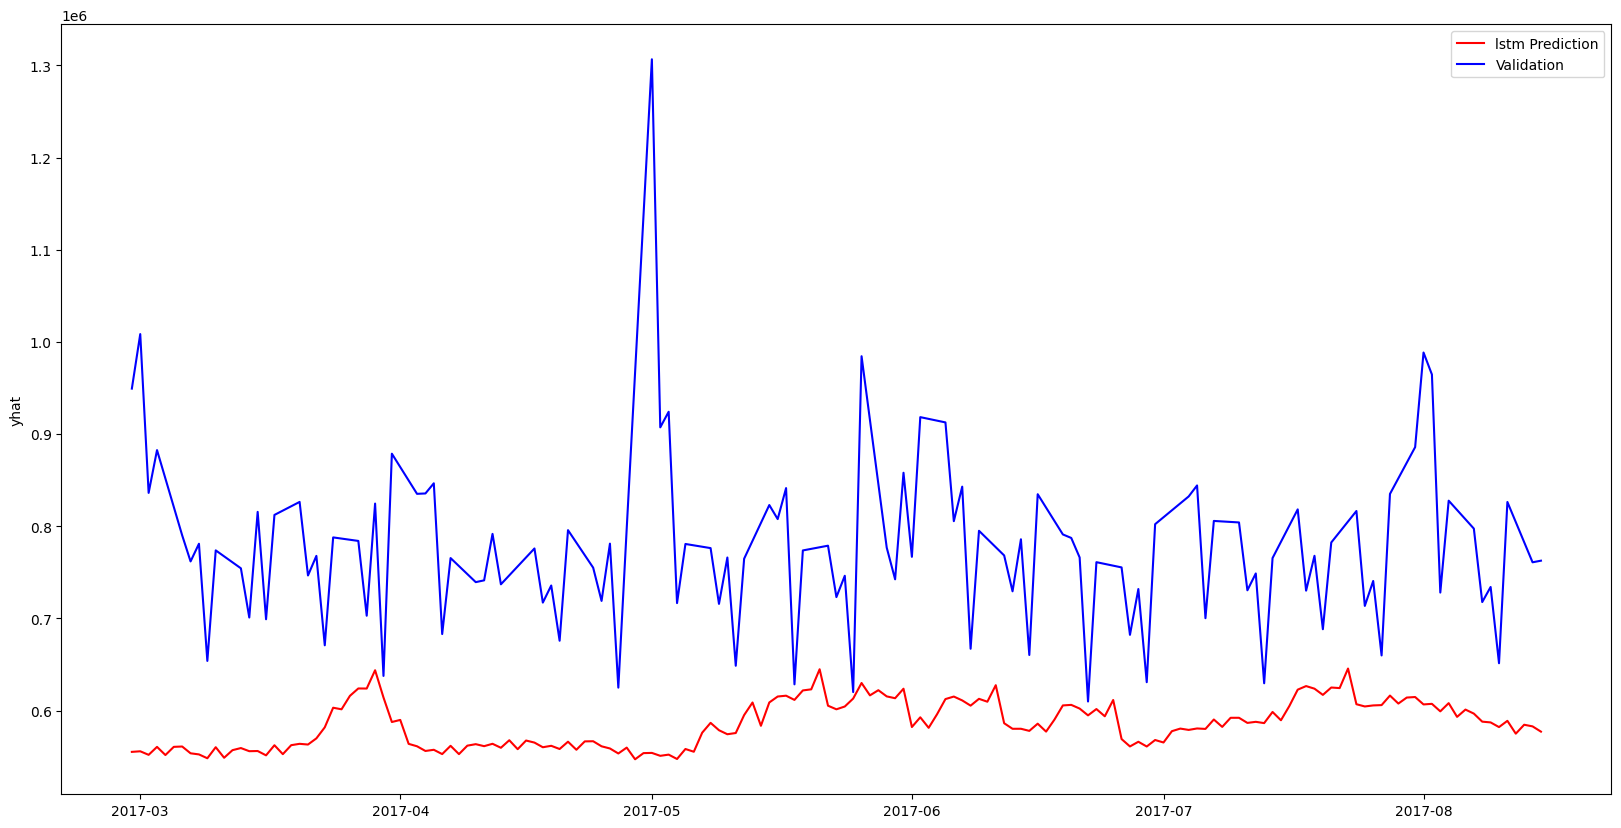

In [69]:
predict_and_plot("lstm simple_default_l1_0_01_l2_0_01 - 2024-01-31 10:14")

1/1 [==============================] - 0s 14ms/step
Predicted 169 days
RMSE: 8946295989.099611


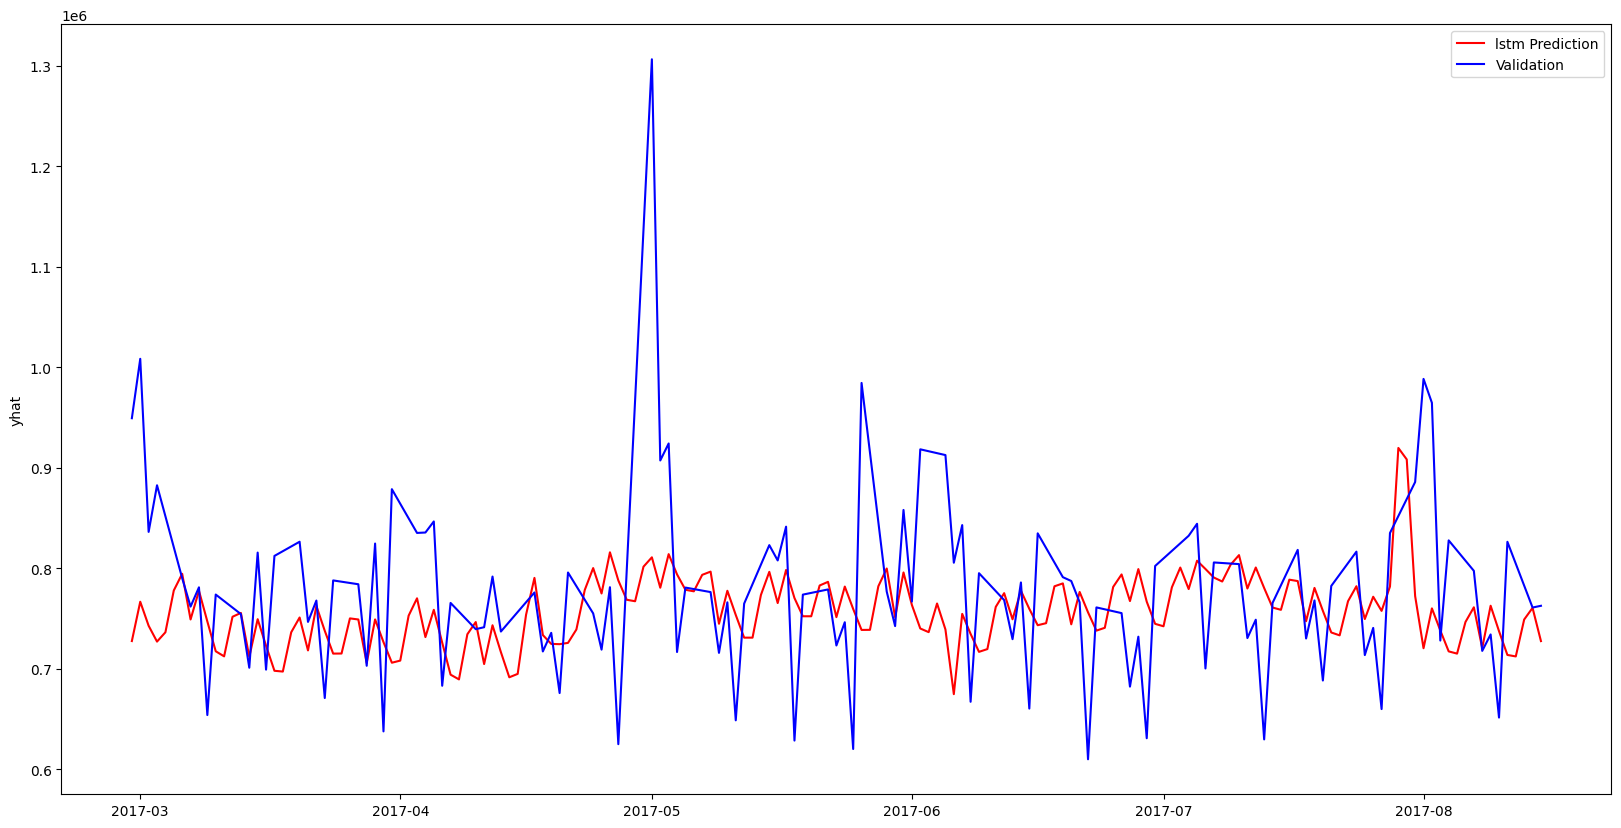

In [70]:
predict_and_plot("lstm simple_batch_size_128_look_back_5 - 2024-01-31 10:10")

In [ ]:
predict_and_plot("lstm default_simple_scaled - 2024-01-31 12:01")

## LSTM multivariate

1/1 [==============================] - 0s 16ms/step
Predicted 169 days
RMSE: 468049545821.87775


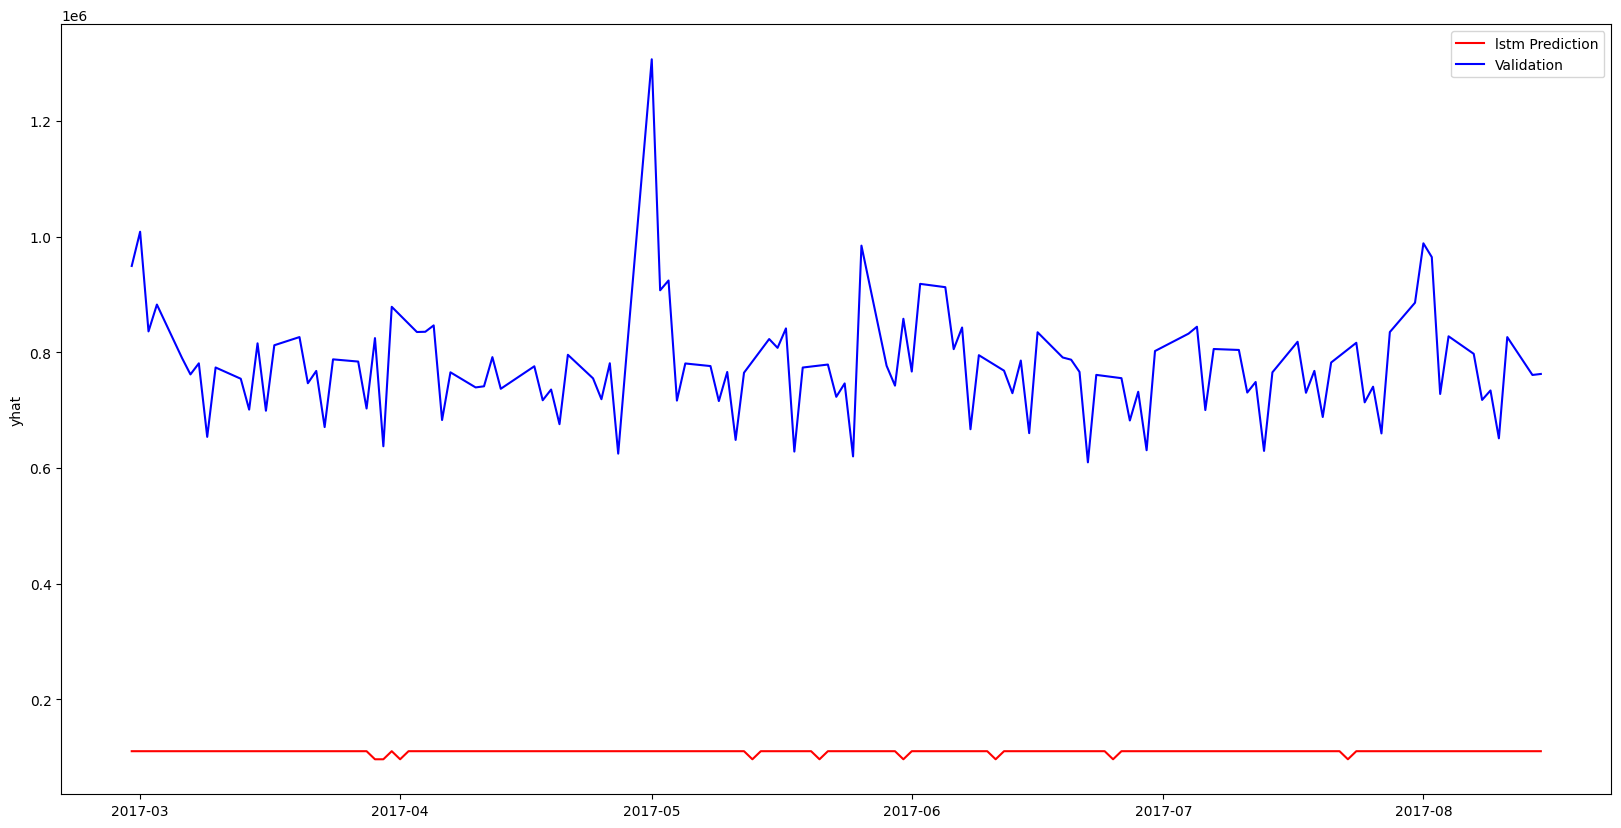

In [71]:
predict_and_plot("lstm default_multivariate - 2024-01-31 09:56")

1/1 [==============================] - 0s 23ms/step
Predicted 169 days
RMSE: 230454189897.56378


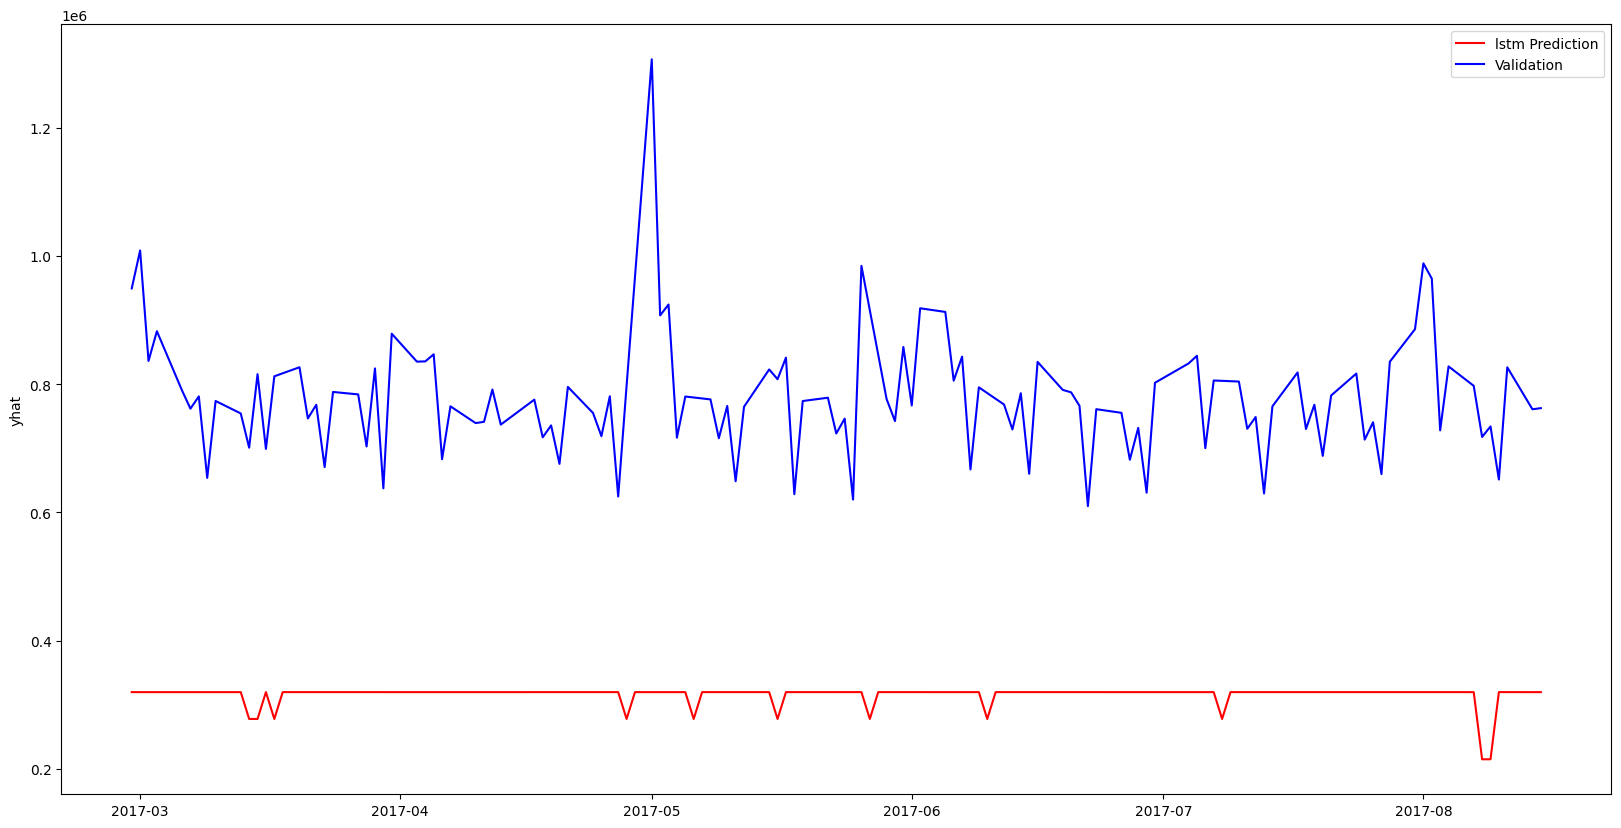

In [72]:
predict_and_plot("lstm multivariate_batch_size_32_look_back_15 - 2024-01-31 10:04")